In [ ]:
import os
from langchain_aws import ChatBedrock
import boto3
from requests_aws4auth import AWS4Auth
from langchain_community.embeddings import BedrockEmbeddings
from langchain_community.vectorstores import OpenSearchVectorSearch
from opensearchpy import RequestsHttpConnection


session = boto3.Session()
credentials = session.get_credentials()
auth_creds = AWS4Auth(
    region="eu-west-3",
    service="aoss",
    refreshable_credentials=credentials,
)
authentication_creds=(os.getenv("OPENSEARCH_ADMIN"), os.getenv("OPENSEARCH_ADMIN_PASSWORD"))
llm = ChatBedrock(
    model_id="amazon.titan-text-express-v1", region_name="eu-west-3"
)

embedding_model = BedrockEmbeddings(
    model_id="cohere.embed-english-v3", region_name="eu-west-3"
)

In [ ]:
vectorstore = OpenSearchVectorSearch(
    index_name="ca_test",
    opensearch_url="https://search-caddy-vector-db-qocexipbio42soi53zdl5zzcqy.eu-west-2.es.amazonaws.com",
    http_auth=authentication_creds,
    embedding_function=embedding_model,
    connection_class=RequestsHttpConnection,
)

In [ ]:
retriever = vectorstore.as_retriever(search_type='mmr',search_kwargs={"k": 10})

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt =  PromptTemplate.from_template("""You are an AI assistant tool helping advisors provide information to people seeking legal advise. 
Provide all the relevant information from the following DOCUMENTS required to answer the QUESTION.

QUESTION:
{question}

DOCUMENTS:
{context}
""")
rag_chain = prompt | llm | StrOutputParser()


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
    Only respond with a single word return nothing else (no whitespace).
    """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | llm |StrOutputParser()

In [ ]:
question="help with mortgage"
docs = retriever.invoke(question)

In [ ]:
retrieval_grader.invoke({'document': docs[0], 'question':question})

In [ ]:
from typing import Annotated
from pprint import pprint


from typing_extensions import TypedDict

from langchain.schema import Document
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: list[str]


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


def retrieval(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    full_documnes = [d.metadata['raw_markdown'] for d in documents]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    print(f"Docs retrieved: {len(documents)}")
    filtered_docs = []
    for d in documents:
        relevance = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = relevance
        if "yes" in grade:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    print(f"Docs After filtering: {len(filtered_docs)}")
    return {"documents": filtered_docs, "question": question}


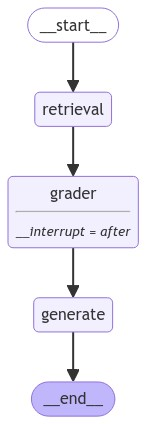

In [196]:

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieval", retrieval) 
workflow.add_node("grader", grade_documents)  
workflow.add_node("generate", generate)  


workflow.add_edge(START, "retrieval")
workflow.add_edge("retrieval", "grader")
workflow.add_edge("grader", "generate")
workflow.add_edge("generate", END) 



checkpointer = MemorySaver()

app = workflow.compile(
    checkpointer=checkpointer,
    interrupt_after=["grader"],
)

display(Image(app.get_graph().draw_mermaid_png()))

In [197]:
question = "What can I do to help if I can't afford to pay for food can I use a foodbank?"

initial_state: GraphState = dict(
    question=question
)
config = {"configurable": {"thread_id": "1"}}
response = app.invoke(initial_state, config=config)
print("""Please select which of the following documents you would like to use for generation:""")
docs = app.get_state(config).values['documents']
docs

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
Docs retrieved: 10
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
Docs After filtering: 6
Please select which of the following documents you would like to use for generation:


[Document(metadata={'source_url': 'https://www.citizensadvice.org.uk/consumer/energy/energy-supply/problems-with-your-energy-bill/your-gas-or-electricity-supplier-has-put-up-its-prices/', 'markdown_length': 4562, 'raw_markdown': "#  Your energy supplier has put its prices up\nThis advice applies to England.  See advice for [See advice for Northern\nIreland](/northern-ireland/consumer/energy/energy-supply/problems-with-your-\nenergy-bill/your-gas-or-electricity-supplier-has-put-up-its-prices/), [See\nadvice for Scotland](/scotland/consumer/energy/energy-supply/problems-with-\nyour-energy-bill/your-gas-or-electricity-supplier-has-put-up-its-prices/),\n[See advice for Wales](/wales/consumer/energy/energy-supply/problems-with-\nyour-energy-bill/your-gas-or-electricity-supplier-has-put-up-its-prices/)\nIf your gas or electricity supplier increases its prices, they should tell you\nin a reasonable amount of time before the change takes place. This is called\ngiving you notice.\nHow much noti

In [198]:
app.update_state(config, {"documents": [docs[1]]})
response = app.invoke(None, config=config)
pprint(response['generation'])

---GENERATE---
(' You can ask your nearest Citizens Advice to refer you to a food bank. '
 "They'll usually make an appointment for you to discuss your situation with "
 'an adviser first.\n'
 "The adviser will ask you some questions to check you're eligible for the "
 "food bank. If you're eligible, they'll give you a voucher for your nearest "
 'food bank.\n'
 "They can also check if you should be getting any benefits you're not "
 'currently claiming and tell you about other local help you could get. The '
 'adviser can give you advice about budgeting and any debts you have.\n'
 '[Find your nearest Citizens Advice](/about-us/contact-us/contact-us')
